## Transfer Learning : Fine Tuning 


In [43]:
# Initiating GPU
import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("CUDA Support:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


CUDA Support: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
## Use for the helper script
from helper import *
import datetime
from helper import create_tensorboard_callback

import os

In [3]:
# Getting the data 10% 
walk_through_dir('10_food_classes_10_percent/10_food_classes_10_percent')


There are 2 directories and 0 images in '10_food_classes_10_percent/10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/steak'.
There are

In [4]:
# creating directories

train_dir = '10_food_classes_10_percent/10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/10_food_classes_10_percent/test'

- Using models pretrained from tf.keras.applications
---
Not using the image Generator for preprocessing td.data.Dataset


In [5]:
import tensorflow as tf

IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE,
                                                                        )


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                 )


Found 750 files belonging to 10 classes.


I0000 00:00:1739392070.866776  137974 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4842 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# Example of batch of data 

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.37229584e+02 5.82295914e+01 2.82295914e+01]
   [1.40168365e+02 6.11683655e+01 3.05714283e+01]
   [1.41219391e+02 6.04336739e+01 2.97908154e+01]
   ...
   [1.13637825e+02 5.50663567e+01 3.88520927e+01]
   [1.13642860e+02 5.46428566e+01 3.86428566e+01]
   [1.17714355e+02 5.57143555e+01 4.07143555e+01]]

  [[1.40045914e+02 6.10459213e+01 3.10459175e+01]
   [1.43647964e+02 6.26479607e+01 3.26479607e+01]
   [1.47015305e+02 6.63724518e+01 3.35867348e+01]
   ...
   [1.10540779e+02 5.35407753e+01 3.65407753e+01]
   [1.16071457e+02 5.70714569e+01 4.10714569e+01]
   [1.18596909e+02 5.65969048e+01 4.15969048e+01]]

  [[1.38280609e+02 5.77091827e+01 2.84948978e+01]
   [1.42357147e+02 6.13571434e+01 3.13571434e+01]
   [1.45806122e+02 6.27602043e+01 3.03316326e+01]
   ...
   [1.10168350e+02 5.33826141e+01 3.63826141e+01]
   [1.14984734e+02 5.59847298e+01 3.99847298e+01]
   [1.18214249e+02 5.68571091e+01 4.16428223e+01]]

  ...

  [[1.31244873e+02 1.55244873e+02 7.92448730e+01]
   [1

2025-02-12 21:27:52.065687: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Sequential APIs Vs Functional APIs

- Building Another Feature Extraction model with "Keras Functional API" : Gives more Flexibility with models
- Inputs to the models are to be the same as the model was trained on : See Documentation for this 
---
### Average pool the outputs of the base model (aggregates all the most important weights : Reducing the number of computations)
---
*EfficientNet has Rescaling built in*

In [8]:
# Model 0 
import tf_keras
# Creating base model , with keras.application

base_model = tf_keras.applications.EfficientNetB0(include_top = False)


# Freezing the base model (underlying Weights are not changed)

base_model.trainable = False 

# Create inputs in the mdoel

inputs = tf_keras.layers.Input(shape = (224, 224 , 3), name = "input_layer")

# IF ResNet then the inputs need to be normalized 
# x = tf_keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model 

x = base_model(inputs)
print(f"Shape after passing inputs to base_model :{x.shape}")

# Average pool the outputs of the base model (aggregates all the most important weights : Reducing the number of computations)

x = tf_keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer") (x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Output Activation Layer 

outputs = tf_keras.layers.Dense(10, activation= "softmax", name = "output_layer")(x)

# Combining inputs and outputs in a model 

model_0 = tf_keras.Model(inputs, outputs)





Shape after passing inputs to base_model :(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [9]:
# Compiling the model 

model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf_keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [44]:
# Fitting 

from tf_keras.callbacks import TensorBoard

history_0 = model_0.fit(train_data_10_percent,
                             epochs=10,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                    experiment_name="10_percent_feature_extraction")])


Saving TensorBoard log files to: tensorflow_hub/10_percent_feature_extraction/20250212-220743
Epoch 1/10
24/24 [==============================] - 4s 126ms/step - loss: 0.2809 - accuracy: 0.9493 - val_loss: 0.4337 - val_accuracy: 0.8734
Epoch 2/10
24/24 [==============================] - 3s 112ms/step - loss: 0.2659 - accuracy: 0.9573 - val_loss: 0.4118 - val_accuracy: 0.8799
Epoch 3/10
24/24 [==============================] - 3s 113ms/step - loss: 0.2500 - accuracy: 0.9573 - val_loss: 0.4216 - val_accuracy: 0.8701
Epoch 4/10
24/24 [==============================] - 3s 109ms/step - loss: 0.2260 - accuracy: 0.9587 - val_loss: 0.4016 - val_accuracy: 0.8783
Epoch 5/10
24/24 [==============================] - 3s 109ms/step - loss: 0.2090 - accuracy: 0.9667 - val_loss: 0.4081 - val_accuracy: 0.8816
Epoch 6/10
24/24 [==============================] - 3s 109ms/step - loss: 0.1988 - accuracy: 0.9693 - val_loss: 0.3938 - val_accuracy: 0.8734
Epoch 7/10
24/24 [==============================] - 3s

In [11]:
# Evaluation of Full Dataset

model_0.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.4343 - accuracy: 0.8852


[0.43434756994247437, 0.885200023651123]

In [12]:
# Checking the layers in the base_model 

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.multiply
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activat

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

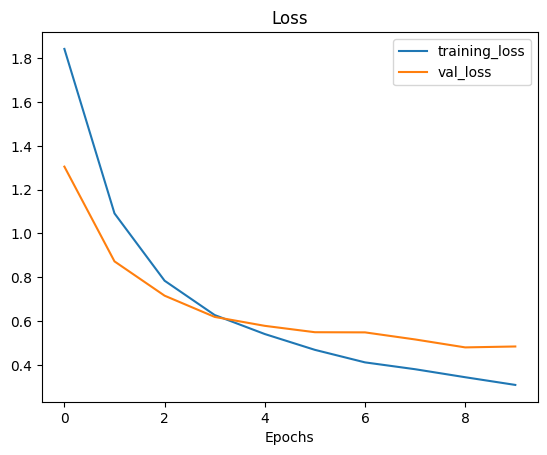

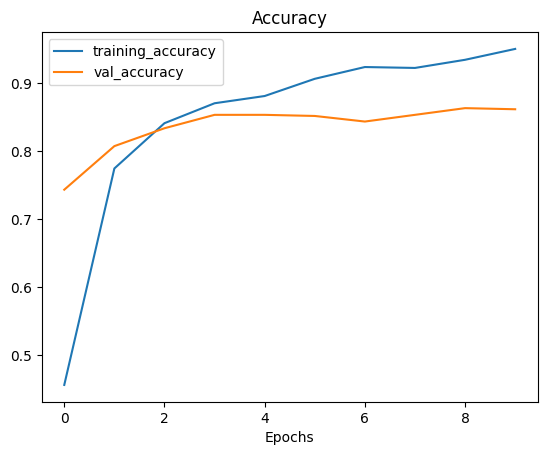

In [14]:
plot_loss_curves(history_0)

### Feature Vectors : Global Average Pooling 2D Layer :

##### Its the learned representation of input data ( compressed from from the POV of the moddel )

- If a tensor after passing through the base model has shape (None , 7 ,7 1280)
- When it passes through GlobalAveragePooling2D it becomes (None, 1280)
- Testing with similar shaped Tensor , (1, 4, 4, 3),
- And pass itt through a GlobalAveragePooling2D



In [15]:
# Inout shape 

input_shape = (1, 4, 4, 3)

# Random Tensor 

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : {input_tensor}")


# Pass the Random tensor to a GlobalAveragePooling2D Layer

global_average_pooling_layer = tf_keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D Global Average Pooled Random tensor : {global_average_pooling_layer}")

# Shape of Tensors 

print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of 2D Global Average Pooled Random tensor : {global_average_pooling_layer.shape}")

Random input tensor : [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D Global Average Pooled Random tensor : [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor : (1, 4, 4, 3)
Shape of 2D Global Average Pooled Random tensor : (1, 3)


In [16]:
# Repllicating GlobalAveragePooling2D layer 

tf.reduce_mean(input_tensor, axis = [1, 2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Summary 

1. model_1 : Feature Extraction Transfer Learning, with 1% data , with Data Augmentation 
2. model_2 : Feature Extraction Transfer Learning , with 10% data , with Data Augmentation\
3. model_3 : Fine Tuning Transfer LEarning , 10% data , with Data Augmentation 
4. model_4 : 100% Data , with Data Augmentation 


In [17]:
# Running Transfer Learning Experiment

# Reducing the training data to 1%

# Getting the data 1%

# Inspecting the number of images 
walk_through_dir('10_food_classes_1_percent/10_food_classes_1_percent')

# Creating the directories

train_dir_1_percent = '10_food_classes_1_percent/10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/10_food_classes_1_percent/test'


There are 2 directories and 0 images in '10_food_classes_1_percent/10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/steak'.
There are 0 directories and

In [18]:

# Setup dataloaders

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf_keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf_keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

# Checking the class names

train_data_1_percent.class_names



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Data Augmentation model_0

Embedding the Data Augmentation in the model , passing it as a layer inside the model 

**With experimental_preprocessing** : Utilization of GPU is Possible , for the data Augmentation && the augmentation only happens during the training 



In [24]:
from tf_keras.layers.experimental import preprocessing
import tf_keras

# create data augmentation stage with horizontal flipping, rotations, zooms etc

data_augmentation = tf_keras.Sequential([preprocessing.RandomFlip('horizontal'),
                                        preprocessing.RandomRotation(0.2),
                                        preprocessing.RandomZoom(0.2),
                                        preprocessing.RandomHeight(0.2),
                                        preprocessing.RandomWidth(0.2),
                                        preprocessing.Rescaling(1./255),
                                        ], name="data_augmentation")

In [20]:
# Visualization the data augmentation layer

# View aa random image and compare to its augmented version


import os
import matplotlib.image as mpimg
import os
import random 


target_class = random.choice(train_data_1_percent.class_names)
target_dir = "/home/akhil/Documents/Tf_Local/10_food_classes_1_percent/10_food_classes_1_percent/train/" + target_class 
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)



/home/akhil/Documents/Tf_Local/10_food_classes_1_percent/10_food_classes_1_percent/train/hamburger/840018.jpg


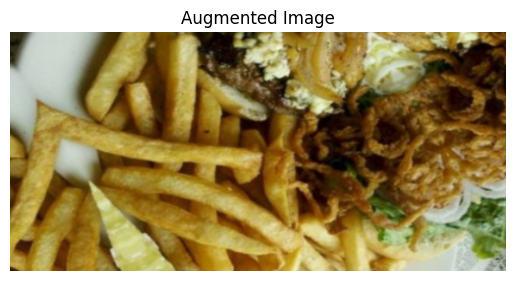

In [26]:
#Reading the random image 


# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze(augmented_img)

plt.imshow(augmented_img.numpy())
plt.axis(False)
plt.title("Augmented Image")
plt.show()
# print(augmented_img)

Original Image Min/Max: 0 255
Augmented Image Min/Max: 0.0 0.98187786


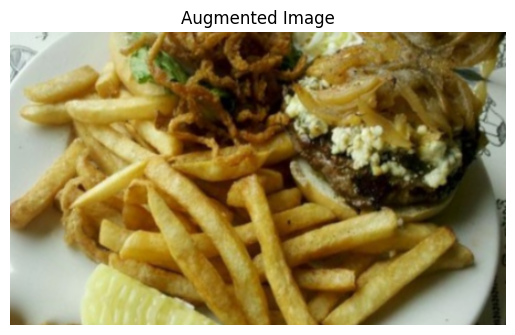

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

# Load the image
img = mpimg.imread(random_image_path)

# Ensure the image values are between 0 and 1
print("Original Image Min/Max:", img.min(), img.max())

# Apply augmentation
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze(augmented_img)

# Ensure the augmented image has valid values
print("Augmented Image Min/Max:", augmented_img.numpy().min(), augmented_img.numpy().max())

# Display the image
plt.imshow(augmented_img.numpy())
plt.axis(False)
plt.title("Augmented Image")
plt.show()


In [46]:
# Fabricating model_1 : Feature Extraction Transfer Learning , on 1% of the data augmentation
from tf_keras import layers

# Freezing , base model layers 
input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name="input_layer")
base_model = tf_keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
base_model.trainable = False  # The model is already pre-trained on ImageNet

# Adding the data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the input after they have been augmented, and not train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer as an output
output = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf_keras.Model(inputs, output)

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 10,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # track the model training logs
                                callbacks = [create_tensorboard_callback (dir_name = "tensorflow_hub",
                                                                          experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20250212-221014
Epoch 1/10
3/3 [==============================] - 9s 1s/step - loss: 2.3784 - accuracy: 0.0714 - val_loss: 2.3141 - val_accuracy: 0.1069
Epoch 2/10
3/3 [==============================] - 2s 697ms/step - loss: 2.3299 - accuracy: 0.1143 - val_loss: 2.3294 - val_accuracy: 0.0921
Epoch 3/10
3/3 [==============================] - 2s 665ms/step - loss: 2.3514 - accuracy: 0.1000 - val_loss: 2.3450 - val_accuracy: 0.0872
Epoch 4/10
3/3 [==============================] - 1s 663ms/step - loss: 2.3556 - accuracy: 0.0857 - val_loss: 2.3379 - val_accuracy: 0.1003
Epoch 5/10
3/3 [==============================] - 1s 673ms/step - loss: 2.3419 - accuracy: 0.1000 - val_loss: 2.3277 - val_accuracy: 0.0921
Epoch 6/10
3/3 [==============================] - 1s 650ms/step - loss: 2.3295 - accuracy: 0.1000 - val_loss: 2.3200 - val_accuracy: 0.1036
Epoch 7/10
3/3 [==============================] - 2s 684ms/step - loss: 2.3314 -

In [48]:
# Evaluating on the full test dataset

results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug


79/79 [==============================] - 5s 62ms/step - loss: 2.3232 - accuracy: 0.1000


[2.3231751918792725, 0.10000000149011612]

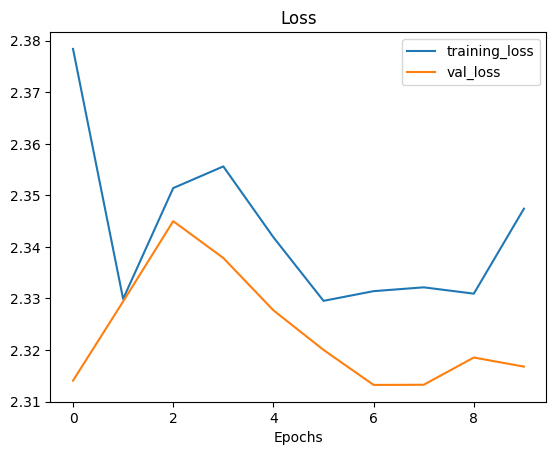

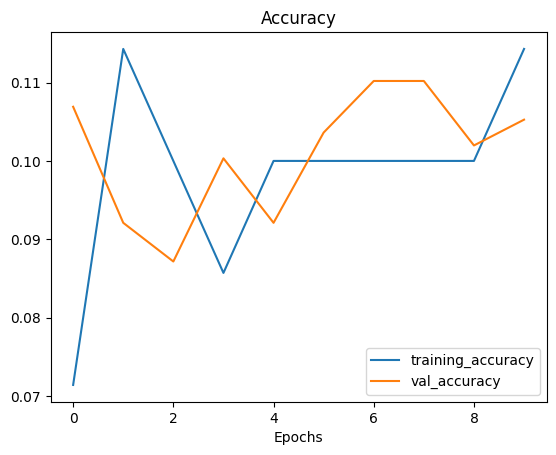

In [49]:
# Data augmentation loss curcees , with 1 % data , with augmentaion 

plot_loss_curves(history_1_percent)
